In [1]:
# Load relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings
from sklearn.cluster import KMeans 

In [2]:
## load data set
carmax_df = pd.read_csv('CaseDataRemodeled.csv')
top10_df = pd.read_csv('Top10ByIncome.csv')

## Time to Cluster - Gonna use k-means initially 




In general, we can cluster observations on the basis of the features in order to identify subgroups among the observations, or we can cluster fea- tures on the basis of the observations in order to discover subgroups among the features. In what follows, for simplicity we will discuss clustering obser- vations on the basis of the features, though the converse can be performed by simply transposing the data matrix.

In [3]:
top10_df.columns
top10_df = top10_df.drop('Unnamed: 0', axis=1)

In [4]:
top10_df['purchase_model']

0        CAMRY
1       ALTIMA
2      COROLLA
3       MALIBU
4       ACCORD
        ...   
115     ACCORD
116    COROLLA
117      CIVIC
118       CR-V
119      FOCUS
Name: purchase_model, Length: 120, dtype: object

In [5]:
cluster_df = carmax_df[carmax_df['purchase_model'].isin(list(set(top10_df['purchase_model'])))]
cluster_df = cluster_df.drop('insert_num', axis=1)

In [6]:
cluster_df

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_age,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,post_purchase_satisfaction,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class
1,FORD,F150,2007,15001.0,20000.0,0,0,51 - 60,0 - 20000,F,1,19.0,?,0,0,Fifties,truck
2,BMW,328,2010,25001.0,30000.0,1,1,41 - 50,60001 - 80000,F,1,21.0,?,0,0,Forties,sedan
5,NISSAN,ALTIMA,2009,15001.0,20000.0,1,1,21 - 30,60001 - 80000,U,0,2.0,?,1,1,Twenties,sedan
8,FORD,ESCAPE,2010,15001.0,20000.0,1,1,41 - 50,40001 - 60000,U,1,14.0,?,1,0,Forties,suv
10,NISSAN,SENTRA,2009,10001.0,15000.0,0,1,61 - 70,20001 - 40000,U,0,NaN,?,0,1,Sixties,sedan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355854,FORD,FOCUS,2013,20001.0,25000.0,1,1,31 - 40,100001 - 120000,M,1,4.0,?,0,2,Thirties,sedan
355860,HYUNDAI,SONATA,2011,20001.0,25000.0,1,0,41 - 50,?,M,0,7.0,?,0,1,Forties,sedan
355864,HONDA,ACCORD,2007,15001.0,20000.0,0,1,21 - 30,20001 - 40000,F,0,12.0,?,0,0,Twenties,coupe
355866,TOYOTA,RAV4,2011,20001.0,25000.0,1,1,51 - 60,40001 - 60000,F,1,3.0,?,0,0,Fifties,suv


In [7]:
len(list(set(top10_df['purchase_model'])))

30

In [8]:
cluster_df.dtypes

purchase_make                   object
purchase_model                  object
purchase_vehicle_year            int64
purchase_price_LB              float64
purchase_price_UB              float64
trade_in                         int64
vehicle_financing                int64
customer_age                    object
customer_income                 object
customer_gender                 object
customer_previous_purchase       int64
customer_distance_to_dealer    float64
post_purchase_satisfaction      object
vehicle_warranty_used            int64
subsequent_purchases             int64
AgeBin                          object
purchase_class                  object
dtype: object

In [9]:
cluster_df = cluster_df.drop('customer_age', axis=1)
cluster_df = cluster_df.drop('post_purchase_satisfaction', axis=1)
cluster_df = cluster_df.drop('purchase_make', axis=1)

In [10]:
# function to transform into numerical bins by normal/gaussian distribution
def categorical_transform(col):
    classnames, factorval, rank = np.unique(col, return_inverse = True,return_counts = True)
    
    temp = np.array(rank)
    temp.sort()
    temp = np.concatenate((temp[::2], temp[~np.isin(temp,temp[::2])][::-1]))

    category_count = {}
    for i in range(len(classnames)):
        category_count[classnames[i]] = rank[i]
    
    vals = [i * 5 for i in range(len(temp))]
    
    for i in range(len(temp)):
        for key, value in category_count.items():
            if value == temp[i]:
                category_count[key] = vals[i]
            
    check_list = list(col)
    for i in range(len(check_list)):
        for key, value in category_count.items():
            if check_list[i] == key:
                factorval[i] = value 
                break
    
    return category_count, factorval

In [11]:
## references of transformation for later 
references = {}

for i in cluster_df.columns:
    if cluster_df[i].dtype == 'object':
        classes = cluster_df[i]
        references[i], cluster_df[i] = categorical_transform(classes)

In [12]:
cluster_df.dtypes

purchase_model                   int64
purchase_vehicle_year            int64
purchase_price_LB              float64
purchase_price_UB              float64
trade_in                         int64
vehicle_financing                int64
customer_income                  int64
customer_gender                  int64
customer_previous_purchase       int64
customer_distance_to_dealer    float64
vehicle_warranty_used            int64
subsequent_purchases             int64
AgeBin                           int64
purchase_class                   int64
dtype: object

In [13]:
cluster_df

,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class
1,90,2007,15001.0,20000.0,0,0,40,10,1,19.0,0,0,35,5
2,25,2010,25001.0,30000.0,1,1,20,10,1,21.0,0,0,20,15
5,75,2009,15001.0,20000.0,1,1,20,0,0,2.0,1,1,25,15
8,50,2010,15001.0,20000.0,1,1,25,0,1,14.0,1,0,20,10
10,45,2009,10001.0,15000.0,0,1,30,0,0,NaN,0,1,15,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355854,100,2013,20001.0,25000.0,1,1,45,5,1,4.0,0,2,30,15
355860,95,2011,20001.0,25000.0,1,0,35,5,0,7.0,0,1,20,15
355864,80,2007,15001.0,20000.0,0,1,30,10,0,12.0,0,0,25,20
355866,35,2011,20001.0,25000.0,1,1,25,10,1,3.0,0,0,35,10


In [14]:
from sklearn.preprocessing import StandardScaler

X = cluster_df.values[:,:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[ 0.46550396, -1.30434939, -0.09561966, ..., -0.44335392,
         1.27463107, -1.64014046],
       [-1.39124196,  0.0304836 ,  1.60397292, ..., -0.44335392,
        -0.86425427,  0.19713047],
       [ 0.03702413, -0.41446073, -0.09561966, ...,  0.39398434,
        -0.15129249,  0.19713047],
       ...,
       [ 0.17985074, -1.30434939, -0.09561966, ..., -0.44335392,
        -0.15129249,  1.11576594],
       [-1.10558875,  0.47542793,  0.75417663, ..., -0.44335392,
         1.27463107, -0.721505  ],
       [-0.24862909,  0.92037227, -0.09561966, ..., -0.44335392,
         0.56166929,  0.19713047]])

Lets run model cluster

In [15]:
num_clusters = 4

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=50,algorithm = "elkan")
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[1 0 3 ... 1 0 1]


In [16]:
cluster_df["Labels"] = labels
cluster_df.head(5)

,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class,Labels
1,90,2007,15001.0,20000.0,0,0,40,10,1,19.0,0,0,35,5,1
2,25,2010,25001.0,30000.0,1,1,20,10,1,21.0,0,0,20,15,0
5,75,2009,15001.0,20000.0,1,1,20,0,0,2.0,1,1,25,15,3
8,50,2010,15001.0,20000.0,1,1,25,0,1,14.0,1,0,20,10,3
10,45,2009,10001.0,15000.0,0,1,30,0,0,NaN,0,1,15,15,1


In [17]:
# can easily change agg argument ---- is mode best?
#cluster_df.groupby('Labels').agg(lambda x: pd.Series.mode(x)[0])
cluster_df.groupby('Labels').mean()

,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class
Labels,,,,,,,,,,,,,,
0,76.049161,2010.960595,23867.333050,28866.333050,0.595065,0.730904,27.089982,6.198817,0.286218,14.204075,0.094986,0.541497,26.191578,12.185976
1,73.031337,2009.792780,12878.911062,17877.911062,0.385825,0.802859,28.764100,6.548819,0.164591,13.657954,0.000000,0.517763,26.009977,14.550263
2,67.216495,2010.103093,16289.659794,21288.659794,0.546392,0.804124,27.164948,6.443299,0.164948,2103.257732,0.216495,0.556701,26.546392,13.711340
3,72.935345,2009.140707,13618.895003,18617.895003,0.445711,0.824451,28.357394,6.513079,0.179312,12.145647,0.999964,0.548754,26.053765,14.164224


#### Questions To Ask:
    How many clusters do we actually want?
    
    Are certain columns influencing negatively or contradicting? 
        e.g. cluster one average make is a Ford with Nissan Altima average model
    

### HCluster

In [18]:
#from sklearn.cluster import FeatureAgglomeration 
#import time as time
#hcluster = FeatureAgglomeration(n_clusters= None, linkage ='ward',distance_threshold = 0).fit(data_scaled)

https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02


https://gist.github.com/PulkitS01/8ac9bf3b54eb59b4e1d4eaa21d3d774e#file-scaling_data-py

In [19]:
from sklearn.preprocessing import normalize
#Normalizer().fit_transform(X))

try:
    hcluster_df = cluster_df.copy().drop('Labels', axis=1).sample(frac = 0.3, random_state = 1)
    X = hcluster_df.values[:,:]
except:
    hcluster_df = cluster_df.copy().sample(frac = 0.3, random_state = 1)
    X = hcluster_df.values[:,:]


X = np.nan_to_num(X)

data_scaled = normalize(X)
data_scaled = pd.DataFrame(data_scaled,columns = hcluster_df.columns)


#cluster_dataset = StandardScaler().fit_transform(X)
#cluster_dataset


In [20]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [21]:
from sklearn.cluster import AgglomerativeClustering
hclustering = AgglomerativeClustering(distance_threshold=None, n_clusters=4, linkage='ward').fit_predict(data_scaled)

In [22]:
# import scipy.cluster.hierarchy as shc

# plt.figure(figsize=(10, 7))
# plt.title("Customer Dendograms")
# dend = shc.dendrogram(shc.linkage(data_frac, method='ward'))

# from scipy.cluster.hierarchy import dendrogram

# plt.title('Hierarchical Clustering Dendrogram')
# # plot the top three levels of the dendrogram
# plot_dendrogram(hclustering, truncate_mode='level', p=3)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

In [23]:
hcluster_df["Labels"] = hclustering
hcluster_df.head(5)

,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class,Labels
229617,30,2006,15001.0,20000.0,1,1,30,5,0,12.0,0,1,20,5,2
318093,30,2008,15001.0,20000.0,0,1,25,5,0,3.0,0,1,35,5,2
202919,125,2008,10001.0,15000.0,1,1,20,5,0,9.0,0,0,35,15,1
295381,40,2008,10001.0,15000.0,0,0,35,0,0,6.0,1,1,30,15,1
324517,75,2012,20001.0,25000.0,0,1,25,0,0,1.0,0,0,30,15,0


### Gaussian Mixture 
https://github.com/ocontreras309/ML_Notebooks/blob/master/GMM_Implementation.ipynb

In [24]:
from sklearn import mixture
import itertools
import matplotlib as mpl
from scipy import linalg

In [25]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(cluster_dataset)
        bic.append(gmm.bic(cluster_dataset))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

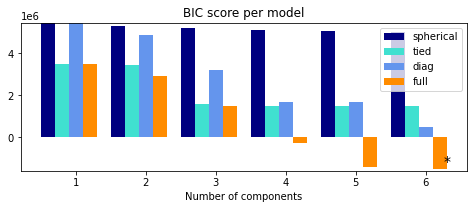

In [26]:
# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

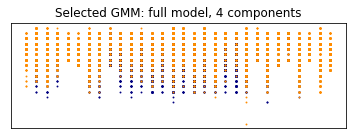

In [27]:
# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 4 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [ ]:
gmm = mixture.GaussianMixture(n_components= 4,
                                      covariance_type= 'full',max_iter=500,n_init=50)
gmmlabels = gmm.fit_predict(cluster_dataset)

In [ ]:
gmcluster_df = cluster_df.copy().drop('Labels', axis=1)
gmcluster_df["Labels"] = gmmlabels

In [ ]:
cluster_df.groupby('Labels').agg(lambda x: pd.Series.mode(x)[0])
#cluster_df.groupby('Labels').mean()

In [ ]:
hcluster_df.groupby('Labels').agg(lambda x: pd.Series.mode(x)[0])
#hcluster_df.groupby('Labels').mean()

In [ ]:
gmcluster_df.groupby('Labels').agg(lambda x: pd.Series.mode(x)[0])

In [ ]:
references.keys()

In [ ]:
def cat_to_names(df,references):
    temp_df = df.copy()
    for key in references.keys():
        vals = references[key]
        for label_key in vals.keys():
            temp_df[key] = temp_df[key].replace(vals[label_key],label_key)
    return temp_df
    

### Let's see what avenues of Customer Segmentation we can Identify

So from above it seems that the way we will do our segmentation is based on 
- Purchase Class
- Purchase Income
- Customer Income
- Customer Gender
- Age

### Clusters by Gender and Puchase Model

In [ ]:
cluster_with_names = cat_to_names(gmcluster_df,references)
counts_of_puchase_models = cluster_with_names.groupby(['Labels','customer_gender','purchase_model']).count().reset_index()
cluster1 = counts_of_puchase_models[counts_of_puchase_models.Labels==0]
cluster1[cluster1.customer_gender=='F'].sort_values(by='purchase_vehicle_year',ascending=False).head(10)

#### Let's Filter out to only keep top 10

In [ ]:
cluster_with_names = cat_to_names(gmcluster_df,references)
counts_of_puchase_models = cluster_with_names.groupby(['Labels','customer_gender','purchase_model']).count().reset_index().rename(columns={"purchase_vehicle_year":"count"})

top10_dfs = []
for i in counts_of_puchase_models['Labels'].unique():
    temp_df=counts_of_puchase_models[counts_of_puchase_models.Labels==i]
    for j in counts_of_puchase_models['customer_gender'].unique():
        temp_df2=temp_df[temp_df.customer_gender==j].sort_values(by='count',ascending=False).head(10)
        top10_dfs.append( temp_df2)
top10_dfs = pd.concat(top10_dfs)
top10_dfs[['Labels','customer_gender','purchase_model','count']]

In [ ]:
print("Simplified from",cluster_with_names.shape[0],"rows to ",top10_dfs.shape[0],"rows.")

### Let's Just Look at the top within this segmentation

In [ ]:
cluster_with_names = cat_to_names(gmcluster_df,references)
counts_of_puchase_models = cluster_with_names.groupby(['Labels','customer_gender','purchase_model']).count().reset_index().rename(columns={"purchase_vehicle_year":"count"})

top10_dfs = []
for i in counts_of_puchase_models['Labels'].unique():
    temp_df=counts_of_puchase_models[counts_of_puchase_models.Labels==i]
    for j in counts_of_puchase_models['customer_gender'].unique():
        temp_df2=temp_df[temp_df.customer_gender==j].sort_values(by='count',ascending=False).head(1)
        top10_dfs.append( temp_df2)
top10_dfs = pd.concat(top10_dfs)[['Labels','customer_gender','purchase_model','count']]
top10_dfs

In [ ]:
counts_of_income_models = cluster_with_names.groupby(['Labels','customer_income','purchase_model']).count().reset_index().rename(columns={"purchase_vehicle_year":"count"})
top10_dfs = []
for i in counts_of_income_models['Labels'].unique():
    temp_df=counts_of_income_models[counts_of_income_models.Labels==i]
    for j in counts_of_income_models['customer_income'].unique():
        temp_df2=temp_df[temp_df.customer_income==j].sort_values(by='count',ascending=False).head(1)
        top10_dfs.append( temp_df2)
top10_dfs = pd.concat(top10_dfs)[['Labels','customer_income','purchase_model','count']]
top10_dfs